In [1]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
import inspect
def select_df(df, **kwargs):
    attrs = df.attrs
    for k, vs in kwargs.items():
        if vs is None:
            df = df[df.__getitem__(k).isna()]
        elif not isinstance(vs, list):
            df = df[df.__getitem__(k) == vs]
        else:
            df = df[df.__getitem__(k).isin(vs)]
    df.attrs = attrs
    return df


def _augment_df(df, fn, name=None, register=None):
    name = fn.__name__ if name is None else name
    params = list(inspect.signature(fn).parameters.keys())
#     fixed = {p: df.attrs["uniq"][p] for p in params if p not in df.columns}
#     params = [p for p in params if p not in fixed
#     if len(fixed) > 0:
#         fn = functools.partial(fn, **fixed)

    def wrapper(row):
        kwargs = {k: row.get(k) for k in params}
        return fn(**kwargs)

    df[name] = df.apply(wrapper, axis=1)

    if register:
        if not register in df.attrs:
            df.attrs[register] = []
        if name not in df.attrs[register]:
            df.attrs[register].append(name)


def augment_df(df, *fns, register=None):
    for f in fns:
        _augment_df(df, f, register=register)

In [3]:
import pandas as pd

df = pd.read_csv('covid_vaccine_data.csv', index_col=0)
df.date = pd.to_datetime(df.date)
df.iso_code = df.iso_code.astype('category')
df.drop(columns=['source_name', 'source_website'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15666 entries, 0 to 15665
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             15666 non-null  category      
 1   country                              15666 non-null  object        
 2   date                                 15666 non-null  datetime64[ns]
 3   total_vaccinations                   9437 non-null   float64       
 4   people_vaccinated                    8754 non-null   float64       
 5   people_fully_vaccinated              6502 non-null   float64       
 6   daily_vaccinations                   15465 non-null  float64       
 7   total_vaccinations_per_hundred       9437 non-null   float64       
 8   people_vaccinated_per_hundred        8754 non-null   float64       
 9   people_fully_vaccinated_per_hundred  6502 non-null   float64       
 10  daily_vacc

In [5]:
# Check how much missing data we have
df.isna().mean() * 100

iso_code                                0.000000
country                                 0.000000
date                                    0.000000
total_vaccinations                     39.761266
people_vaccinated                      44.121026
people_fully_vaccinated                58.496106
daily_vaccinations                      1.283033
total_vaccinations_per_hundred         39.761266
people_vaccinated_per_hundred          44.121026
people_fully_vaccinated_per_hundred    58.496106
daily_vaccinations_per_million          1.283033
vaccines                                0.000000
Population                              7.251372
Full_vaccinations(count)               22.137112
Total_vaccinations(count)               1.589429
dtype: float64

In [6]:
# df.groupby('iso_code')['total_vaccinations'].value_counts()

In [7]:
# Columns that are constant within a country
for c in df.columns:
    if all(len(sdf[c].unique()) == 1 for _, sdf in df.groupby('iso_code')):
        print(c)

iso_code
country
vaccines
Population
Full_vaccinations(count)
Total_vaccinations(count)


In [8]:
# Double check that last couple columns are just max of other columns
print((
df.groupby('iso_code')['Full_vaccinations(count)'].mean() - \
df.groupby('iso_code')['people_fully_vaccinated'].max()
).value_counts())

print((
df.groupby('iso_code')['Total_vaccinations(count)'].mean() - \
df.groupby('iso_code')['total_vaccinations'].max()
).value_counts())

0.0    123
dtype: int64
0.0    193
dtype: int64


In [9]:
# Same for last couple cols
assert 0.0 == df.groupby('iso_code')['Full_vaccinations(count)'].std().sort_values(ascending=False).fillna(0).sum()
assert 0.0 == df.groupby('iso_code')['Total_vaccinations(count)'].std().sort_values(ascending=False).fillna(0).sum()

In [10]:
import numpy as np

In [11]:
np.allclose(
    df.total_vaccinations / df.Population * 100,
    df.total_vaccinations_per_hundred,
#     equal_nan=True,
#     atol=np.inf,
#     rtol=100
)

False

In [12]:
# What does the vaccine column look like?
df[df.iso_code=='ESP'].vaccines.value_counts()

Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    122
Name: vaccines, dtype: int64

In [13]:
df.iso_code.sort_values()

0        ABW
22       ABW
23       ABW
24       ABW
25       ABW
        ... 
15610    ZWE
15609    ZWE
15608    ZWE
15615    ZWE
15665    ZWE
Name: iso_code, Length: 15666, dtype: category
Categories (196, object): ['ABW', 'AFG', 'AGO', 'AIA', ..., 'WSM', 'ZAF', 'ZMB', 'ZWE']

In [14]:
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='iso_code'>

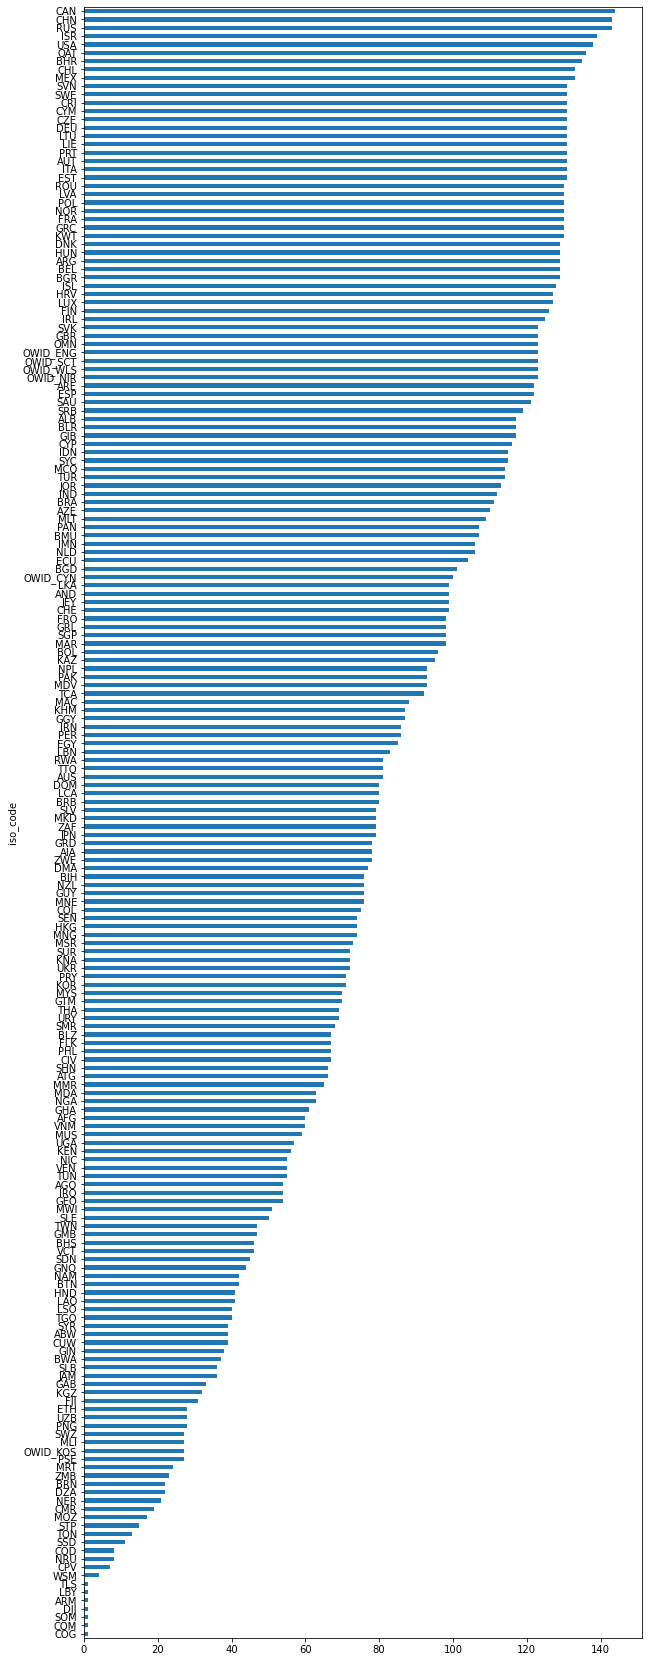

In [15]:
# Look at how much data we have per country
fig, ax = plt.subplots(figsize=(10,30))
df.groupby(by='iso_code').date.count().sort_values(ascending=True).plot(kind='barh', ax=ax)

In [16]:
import seaborn as sns

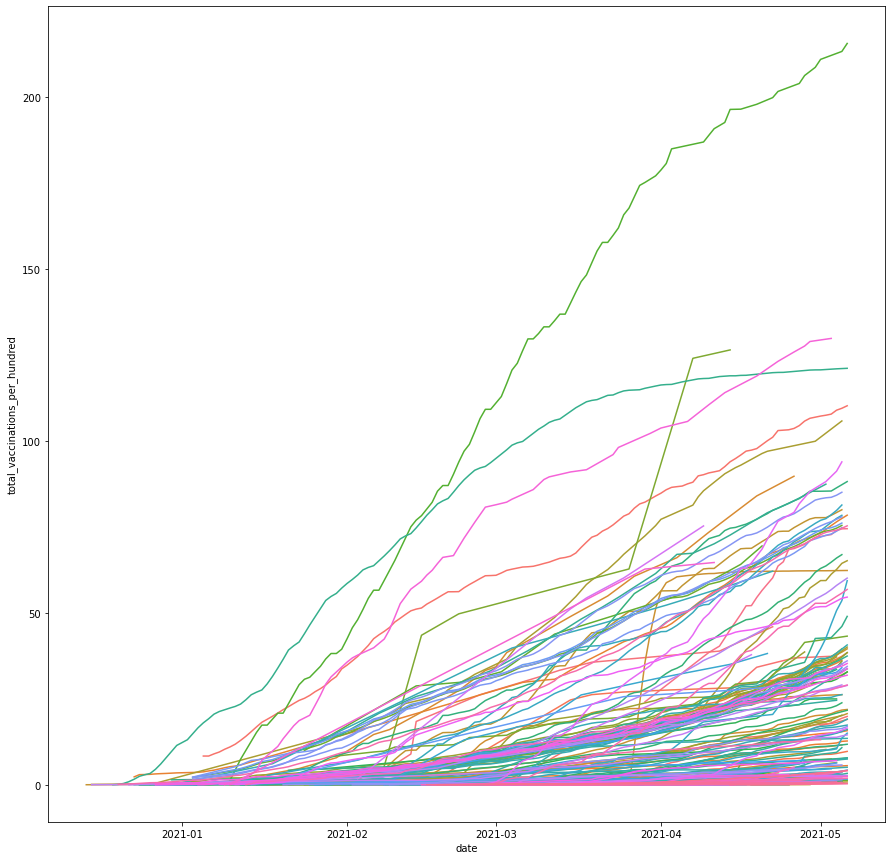

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.lineplot(
    data=df, 
    x='date',
    y='total_vaccinations_per_hundred',
    hue='iso_code',
    legend=False,
    ax=ax,
)

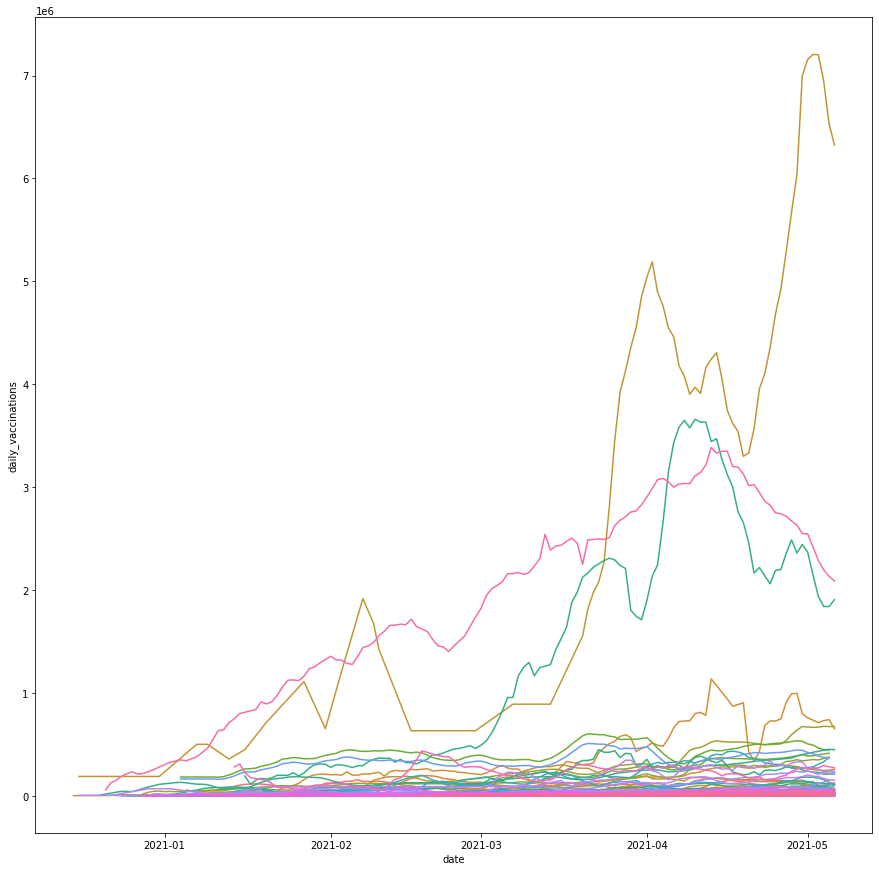

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.lineplot(
    data=df, 
    x='date',
    y='daily_vaccinations',
    hue='iso_code',
    legend=False,
    ax=ax,
)

In [19]:
Europe = ['ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU', 'GIB', 'GRC', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'XKX', 'LVA', 'LIE', 'LTU', 'LUX', 'MKD', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'UKR', 'GBR', 'VAT', 'RSB']

In [20]:
df['in_europe'] = df.iso_code.isin(Europe)

In [21]:
sdf = df[df.in_europe]
sdf = sdf[sdf.Population > 7e6]
sdf = sdf[sdf.iso_code != 'UKR'] # Ukraine is noisy

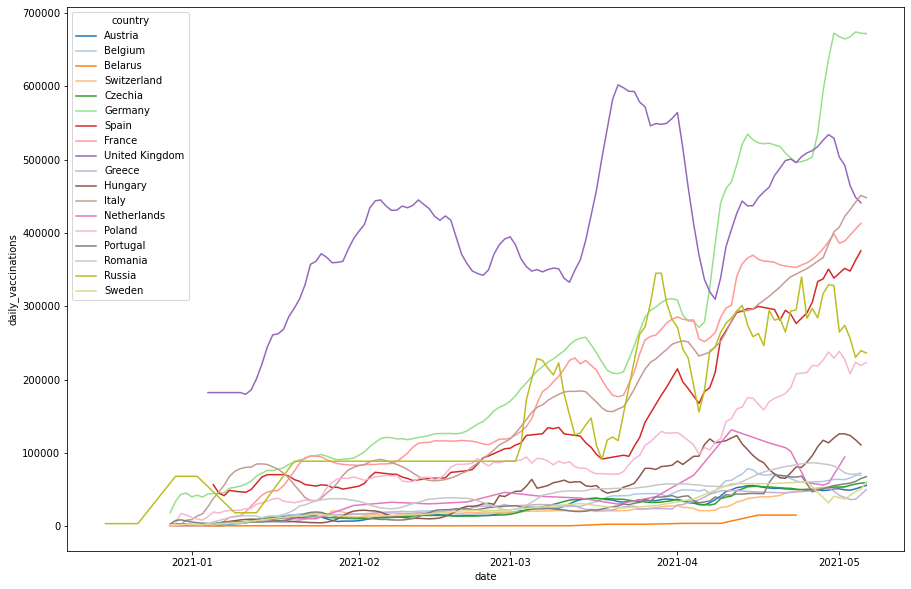

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf, 
    x='date',
    y='daily_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    markers=True,
    ax=ax,
)

[None]

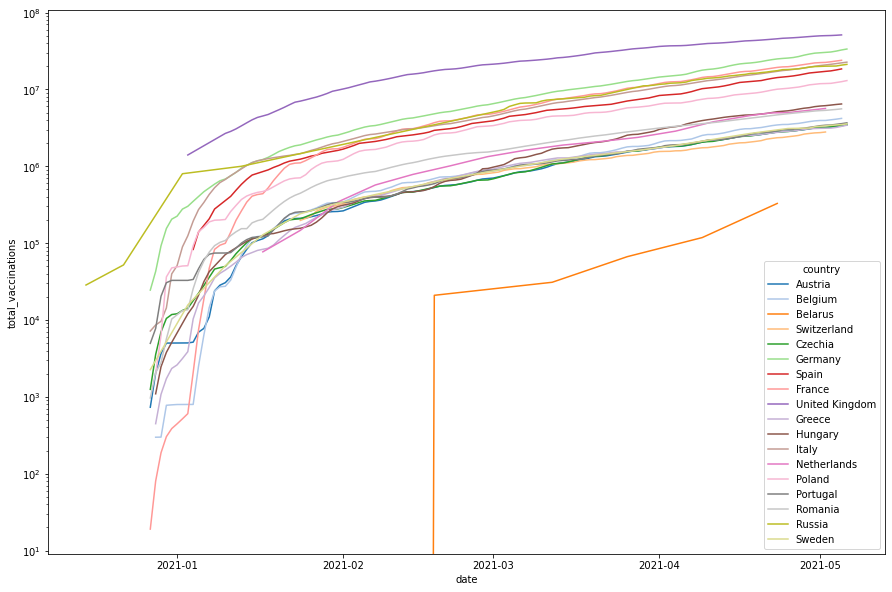

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf, 
    x='date',
    y='total_vaccinations',
    hue='country',
#     legend=False,
    palette='tab20',
    ax=ax,
)
ax.set(yscale='log')

## ^ Paises europeos grandes (excepto UK) tienen una tendencia exponencial bastante clara.

[None]

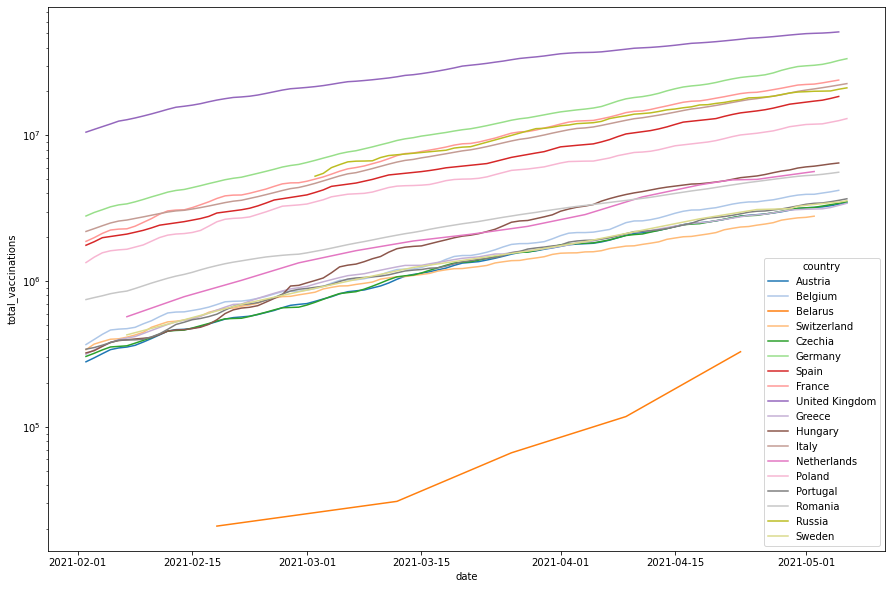

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='total_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

## ^ Esto pide Linear Regression mas que otra cosa

In [25]:
starting_vaccinations = sdf[sdf.date == '2021-02-01'][['iso_code', 'total_vaccinations']].set_index('iso_code')

In [26]:
def normalized_vaccinations(iso_code, total_vaccinations, Population):
    return (total_vaccinations - starting_vaccinations.loc[iso_code]) / Population
    
augment_df(sdf, normalized_vaccinations)

## Normalizamos por la poblacion y la cantidad a principios de febrero, UK va de por libre, el resto van a un ritmo muy claro

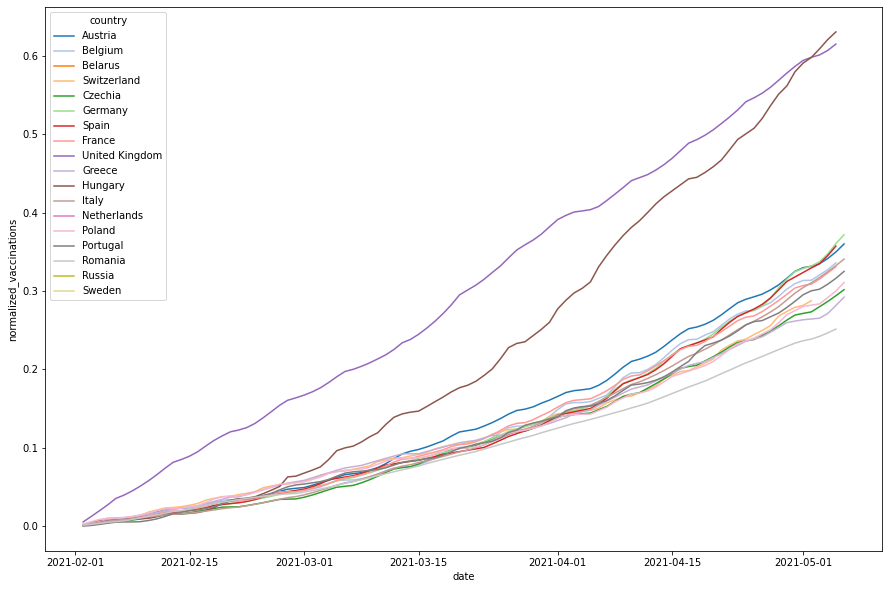

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
# ax.set(yscale='log')

[None]

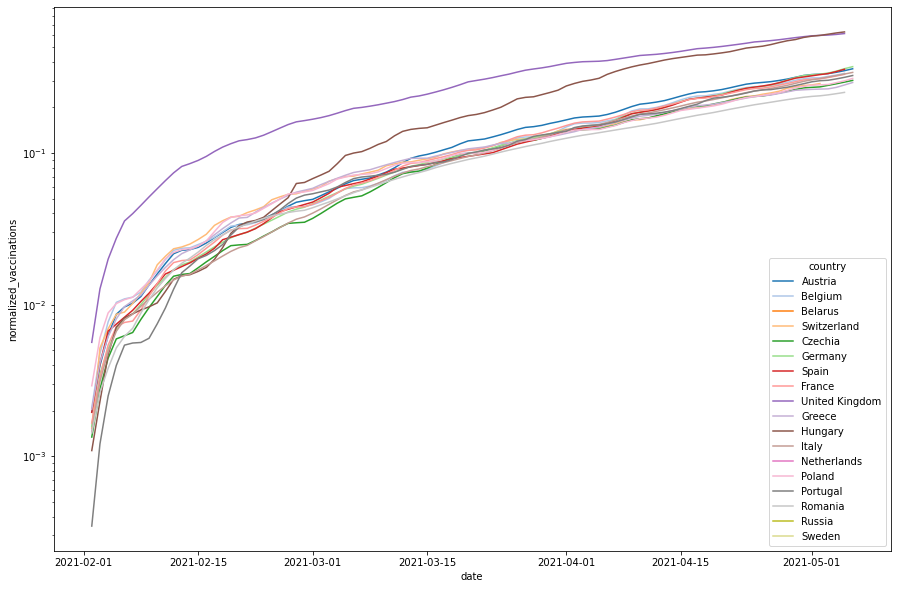

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

[None]

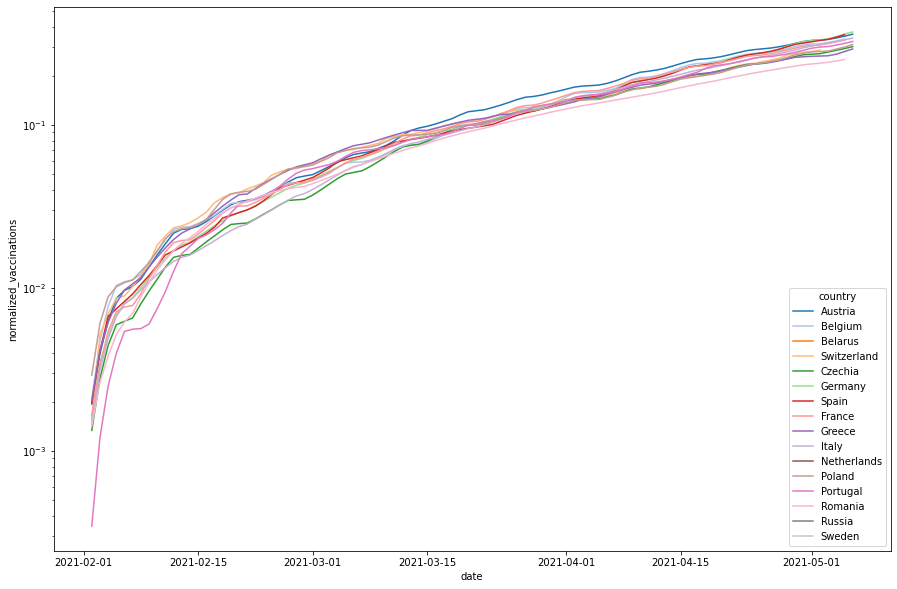

In [29]:
ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]
ssdf = ssdf[ssdf.date > '2021-02']

fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=ssdf, 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
import datetime as dt

In [32]:
data = ssdf.copy()
data = data[~data.normalized_vaccinations.isna()]
data = data[data.date > '2021-03']

In [33]:
X = data.date.map(dt.datetime.toordinal).to_numpy()[:, None]
y = data.normalized_vaccinations.to_numpy()[:, None]
reg = LinearRegression().fit(X, np.log(y))

In [34]:
reg.coef_ , reg.intercept_

(array([[0.02754197]]), array([-20324.70066546]))

In [35]:
pd.isna(X).any()

False

In [36]:
dates = pd.date_range(start='2021-02-01', end='2021-06-01')
Xt = dates.map(dt.datetime.toordinal).to_numpy()[:, None]
yt = reg.predict(Xt)

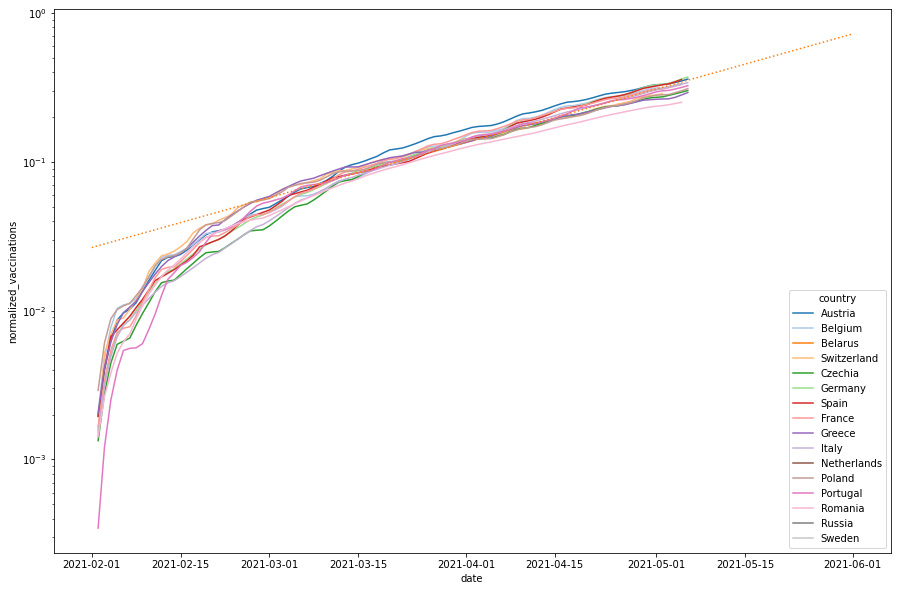

In [37]:
ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=ssdf[ssdf.date > '2021-02'], 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

ax.plot(dates, np.exp(yt), ls=':')

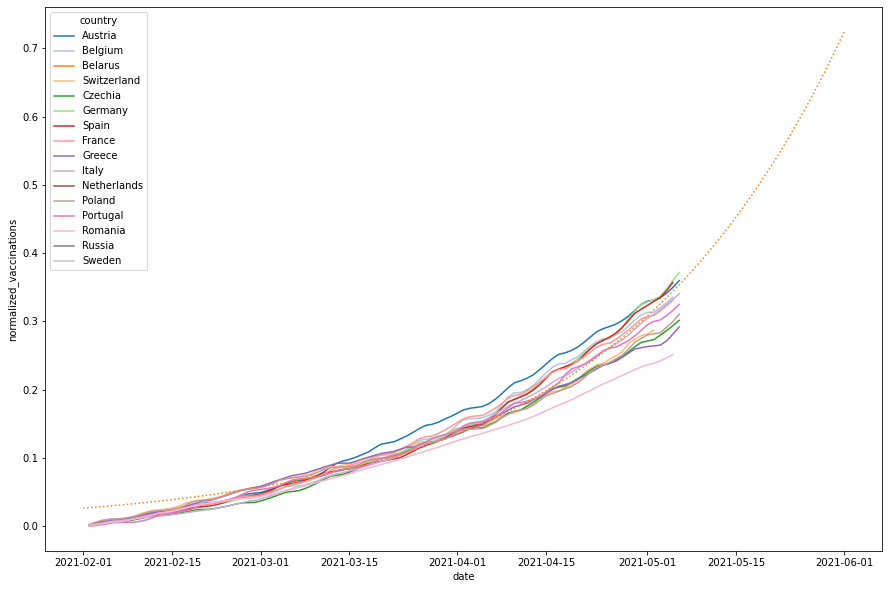

In [38]:
ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=ssdf[ssdf.date > '2021-02'], 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
# ax.set(yscale='log')

ax.plot(dates, np.exp(yt), ls=':')

In [39]:
# Esto es 

In [40]:
# # min_total = sdf.groupby('iso_code').agg({'total_vaccinations': lambda g: g.min(skipna=True)}).fillna(0)
# # min_total.rename(columns={'total_vaccinations': 'min_existing'}, inplace=True)
# # min_total = pd.merge(min_total, sdf, on='iso_code')['min_existing']

# sdf['total_from_daily'] = sdf.groupby('iso_code').daily_vaccinations.cumsum()

# fig, ax = plt.subplots(figsize=(15,10))
# g = sns.lineplot(
#     data=sdf, 
#     x='date',
#     y='total_from_daily',
#     hue='country',
# #     legend=False,
#     ax=ax,
# )
# ax.set(yscale='log')

# sdf['daily_error'] = sdf['total_from_daily'] - sdf['total_vaccinations']

# fig, ax = plt.subplots(figsize=(15,10))
# g = sns.lineplot(
#     data=sdf, 
#     x='date',
#     y='daily_error',
#     hue='country',
# #     legend=False,
#     ax=ax,
# )
# # ax.set(yscale='log')